In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from google.cloud import bigquery
# Initialize client
client = bigquery.Client()

In [25]:
# Define your query
query = "SELECT * FROM `just-data-sandbox-oos.ENEL_645.FE9_merged_features`"

# Execute query and load into DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()

,uid,createdTime,resId,itemId,qty,scenario,hour,dayPhase,AM_PM,dd,...,irNumOOS1w,irOOSRate1h,irOOSRate3h,irOOSRate6h,irOOSRate1d,irOOSRate3d,irOOSRate1w,irTimeSincePrevRestock,irPrevRestockTime,irTimeSinceLastDelivered
0,d943c0ce-2be3-437b-9df8-eceede24fb7a,2025-01-01 07:08:33+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,b95ce666368b54f741ff3eedb093be070ebeb762e426f4...,5,DELIVERED,7,Morning,AM,01,...,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
1,1ac96341-6b39-4ff4-8f47-d343c9e96ee8,2025-01-01 08:13:08+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,1,DELIVERED,8,Morning,AM,01,...,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>
2,ab4a1100-da14-4374-80da-d7b7c2860701,2025-01-01 08:29:38+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,b95ce666368b54f741ff3eedb093be070ebeb762e426f4...,5,DELIVERED,8,Morning,AM,01,...,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,1
3,3ba1d817-06e2-4c73-a02f-e7ecf3074f61,2025-01-01 10:53:21+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,b95ce666368b54f741ff3eedb093be070ebeb762e426f4...,3,DELIVERED,10,Morning,AM,01,...,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,2
4,f29d43b4-e71e-4fbb-96ae-ea376c9d638b,2025-01-01 11:30:48+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,2,DELIVERED,11,Morning,AM,01,...,0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,3


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236570 entries, 0 to 236569
Data columns (total 63 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   uid                       236570 non-null  object             
 1   createdTime               236570 non-null  datetime64[us, UTC]
 2   resId                     236570 non-null  object             
 3   itemId                    236570 non-null  object             
 4   qty                       236570 non-null  Int64              
 5   scenario                  236570 non-null  object             
 6   hour                      236570 non-null  Int64              
 7   dayPhase                  236570 non-null  object             
 8   AM_PM                     236570 non-null  object             
 9   dd                        236570 non-null  object             
 10  weekday                   236570 non-null  object             
 11  

In [27]:
#Encode binary columns
binary_mappings = {
    'scenario': {'DELIVERED': 0, 'OUT_OF_STOCK': 1}
}

for col in binary_mappings.keys():
    if col in binary_mappings:
        df[col] = df[col].map(binary_mappings[col])
df = df.rename(columns={ 'scenario':'isOOS',})

In [28]:
import pandas as pd
import numpy as np

In [29]:
# drop rows of first month, since some of our our features is based on past one month data (ie data 1 month prior to order time does not exist)
# Our data starts from 2025-01-01 07:01:28 UTC.
df['createdTime'] = pd.to_datetime(df['createdTime'], utc=True)

cutoff_times = {
    "1h": pd.Timestamp("2025-01-01 08:01:28", tz='UTC'),
    "3h": pd.Timestamp("2025-01-01 10:01:28", tz='UTC'),
    "6h": pd.Timestamp("2025-01-01 13:01:28", tz='UTC'),
    "1d": pd.Timestamp("2025-01-02 07:01:28", tz='UTC'),
    "3d": pd.Timestamp("2025-01-04 07:01:28", tz='UTC'),
    "1w": pd.Timestamp("2025-01-08 07:01:28", tz='UTC'),
    "1m": pd.Timestamp("2025-02-01 07:01:28", tz='UTC'),
}

# Iterate over the dictionary to apply transformations
for suffix, cutoff in cutoff_times.items():
    cols_to_update = [col for col in df.columns if col.endswith(suffix)]
    df.loc[df['createdTime'] < cutoff, cols_to_update] = pd.NA

df = df.dropna()
df.head()

,uid,createdTime,resId,itemId,qty,isOOS,hour,dayPhase,AM_PM,dd,...,irNumOOS1w,irOOSRate1h,irOOSRate3h,irOOSRate6h,irOOSRate1d,irOOSRate3d,irOOSRate1w,irTimeSincePrevRestock,irPrevRestockTime,irTimeSinceLastDelivered
907,132faff9-743b-43eb-b7fc-88acd859bf18,2025-01-13 09:45:10+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,2,0,9,Morning,AM,13,...,36,0.0,0.0,0.0,0.971429,0.387097,0.142292,1,23,1
909,14e9b2d5-7f5d-4112-add1-cfae76c0530f,2025-01-13 10:40:25+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,2,0,10,Morning,AM,13,...,36,0.0,0.0,0.0,0.942857,0.382979,0.142857,2,23,0
911,8338342e-0a47-4b16-81cb-f04d27960e63,2025-01-13 10:52:56+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,3,0,10,Morning,AM,13,...,36,0.0,0.0,0.0,0.916667,0.378947,0.142292,2,23,0
918,bdbb285c-91a2-4aff-b9ff-48d8cbefa302,2025-01-13 11:53:20+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,1,0,11,Morning,AM,13,...,36,0.0,0.0,0.0,0.882353,0.382979,0.142292,3,23,1
920,63c8a90e-e567-4662-b20a-d9f7f12b89b0,2025-01-13 11:59:15+00:00,007c0cb81363275a5b01a2387a62945960f25f263b9459...,c07c2f435b131daf654a3632f7fcd44a9a4ccb435bb887...,2,0,11,Morning,AM,13,...,36,0.0,0.0,0.0,0.852941,0.378947,0.141732,3,23,0


In [30]:
df.columns

Index(['uid', 'createdTime', 'resId', 'itemId', 'qty', 'isOOS', 'hour',
       'dayPhase', 'AM_PM', 'dd', 'weekday', 'weekday_weekend', 'month',
       'quarter', 'resNumOrders1h', 'resNumOrders3h', 'resNumOrders6h',
       'resNumOrders1d', 'resNumOrders3d', 'resNumOrders1w', 'resQty1h',
       'resQty3h', 'resQty6h', 'resQty1d', 'resQty3d', 'resQty1w',
       'resNumOOS1h', 'resNumOOS3h', 'resNumOOS6h', 'resNumOOS1d',
       'resNumOOS3d', 'resNumOOS1w', 'resTimeSincePrevRestock',
       'irNumOrders1h', 'irNumOrders3h', 'irNumOrders6h', 'irNumOrders1d',
       'irNumOrders3d', 'irNumOrders1w', 'irQty1h', 'irQty3h', 'irQty6h',
       'irQty24h', 'irQty3d', 'irQty1w', 'irTimeSincePrevOrder',
       'irPrevScenario', 'irTimeSincePrevOOS', 'irNumOOS1h', 'irNumOOS3h',
       'irNumOOS6h', 'irNumOOS1d', 'irNumOOS3d', 'irNumOOS1w', 'irOOSRate1h',
       'irOOSRate3h', 'irOOSRate6h', 'irOOSRate1d', 'irOOSRate3d',
       'irOOSRate1w', 'irTimeSincePrevRestock', 'irPrevRestockTime',
       'i

In [31]:
# Encode categorical binary columns using mapping
binary_mappings = {
    'AM_PM': {'AM': 0, 'PM': 1},  # Convert AM/PM to 0/1
    'weekday_weekend': {'Weekday': 0, 'Weekend': 1},  # Convert Weekday/Weekend to 0/1
    'scenario': {'DELIVERED': 0, 'OUT_OF_STOCK': 1},  # Convert scenario to 0/1
}

# Apply mappings
df.replace(binary_mappings, inplace=True)

# Rename columns for clarity
df.rename(columns={'AM_PM': 'isPM', 'weekday_weekend': 'isWeekend', 'scenario': 'isOOS'}, inplace=True)

<ipython-input-31-952896f6ca33>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(binary_mappings, inplace=True)
<ipython-input-31-952896f6ca33>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(binary_mappings, inplace=True)


In [32]:
#train gradient boost tree model with all features, in order to find most important features
#TODO: include one hot encoded featuers too.
from sklearn.metrics import classification_report, confusion_matrix


top_20_features_from_ML = ['irTimeSincePrevOOS', 'irTimeSincePrevOrder', 'irTimeSinceLastDelivered',
              'resTimeSincePrevRestock', 'resQty3d', 'irTimeSincePrevRestock',
              'resNumOrders3d', 'resNumOrders1d', 'resNumOOS1w', 'resQty1d',
              'irNumOrders3d', 'irQty1w', 'resNumOrders3h', 'irPrevRestockTime',
              'isWeekend', 'irQty24h', 'dd', 'irNumOOS1w', 'irNumOOS3d',
              'resNumOrders1w']
data = df[top_20_features_from_ML + ['isOOS']].dropna()  # drop NA to avoid issues


In [33]:
data[top_20_features_from_ML] = data[top_20_features_from_ML].astype('float32')

In [34]:
all_features = [
    "qty", "hour", "isPM", "dd", "isWeekend", "quarter",
    "resNumOrders1h", "resNumOrders3h","resNumOrders1d", "resNumOrders3d", "resNumOrders1w",
    "resQty1h", "resQty3h" ,"resQty6h", "resQty1d", "resQty3d", "resQty1w",
    "resNumOOS1h", "resNumOOS3h", "resNumOOS6h" ,"resNumOOS1d", "resNumOOS3d", "resNumOOS1w",
    "resTimeSincePrevRestock",
    "irNumOrders1h", "irNumOrders3h", "irNumOrders6h" ,"irNumOrders1d", "irNumOrders3d", "irNumOrders1w",
    "irQty1h", "irQty3h", "irQty24h", "irQty3d", "irQty1w",
    "irTimeSincePrevOrder", "irTimeSincePrevOOS",
    "irNumOOS1h","irNumOOS3h", "irNumOOS6h", "irNumOOS1d", "irNumOOS3d", "irNumOOS1w",
    "irTimeSincePrevRestock", "irPrevRestockTime",
    "irTimeSinceLastDelivered"
]
data_all = df[all_features + ['isOOS']].dropna()
data[top_20_features_from_ML] = data[top_20_features_from_ML].astype('float32')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189884 entries, 907 to 236569
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   irTimeSincePrevOOS        189884 non-null  float32
 1   irTimeSincePrevOrder      189884 non-null  float32
 2   irTimeSinceLastDelivered  189884 non-null  float32
 3   resTimeSincePrevRestock   189884 non-null  float32
 4   resQty3d                  189884 non-null  float32
 5   irTimeSincePrevRestock    189884 non-null  float32
 6   resNumOrders3d            189884 non-null  float32
 7   resNumOrders1d            189884 non-null  float32
 8   resNumOOS1w               189884 non-null  float32
 9   resQty1d                  189884 non-null  float32
 10  irNumOrders3d             189884 non-null  float32
 11  irQty1w                   189884 non-null  float32
 12  resNumOrders3h            189884 non-null  float32
 13  irPrevRestockTime         189884 non-null  floa

In [36]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [37]:
class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)     # output layer
        )
    def forward(self, x):
        return self.model(x)

In [38]:
class FocalLoss(nn.Module):
  # Focal Loss for binary classification.
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Controls the balance between positive and negative samples
        self.gamma = gamma # Controls the rate at which easy samples' loss is down-weighted

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

In [39]:
def train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, device, epochs=600):
    """
    Train the model on X_train.
    """
    model.to(device)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    plt.figure(figsize=(8, 5))
    plt.plot(range(epochs), loss_history, label='Training Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return model

In [40]:
def calibrate_model(model, X_train_tensor, y_train_tensor, device):
    """
    Calibrate the trained model using logistic regression (Platt Scaling).
    """
    logits_train = model(X_train_tensor).detach().cpu().numpy()
    y_train_numpy = y_train_tensor.cpu().numpy().ravel()

    calibrator = LogisticRegression()
    calibrator.fit(logits_train, y_train_numpy)

    return calibrator

In [41]:
def evaluate_model(model, calibrator, X_test_tensor, y_test_tensor, device):
    """
    Evaluate the model on X_test and plot results.
    """
    logits_test = model(X_test_tensor).detach().cpu().numpy()
    y_test_numpy = y_test_tensor.cpu().numpy()

    calibrated_probs = calibrator.predict_proba(logits_test)[:, 1]
    y_pred_probs = torch.sigmoid(model(X_test_tensor)).detach().cpu().numpy()

    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_probs, kde=False, color='blue', label='Original y_pred (sigmoid)', stat='percent', bins=30)
    sns.histplot(calibrated_probs, kde=False, color='red', label='Calibrated probs', stat='percent', bins=30)
    plt.title("Distribution of Original y_pred (sigmoid) vs Calibrated Probs")
    plt.xlabel("Probability")
    plt.ylabel("Percentage (%)")
    plt.legend()
    plt.show()

    y_pred_class = (calibrated_probs > 0.5)
    cm = confusion_matrix(y_test_numpy, y_pred_class)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=['Predicted In-stock', 'Predicted OOS'],
                yticklabels=['Actual In-stock', 'Actual OOS'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix with default threshold = 0.5")


    print(classification_report(y_test_numpy, y_pred_class))

    auroc = roc_auc_score(y_test_numpy, calibrated_probs)
    print(f"AUROC: {auroc}")
    return plt

In [42]:
data.columns

Index(['irTimeSincePrevOOS', 'irTimeSincePrevOrder',
       'irTimeSinceLastDelivered', 'resTimeSincePrevRestock', 'resQty3d',
       'irTimeSincePrevRestock', 'resNumOrders3d', 'resNumOrders1d',
       'resNumOOS1w', 'resQty1d', 'irNumOrders3d', 'irQty1w', 'resNumOrders3h',
       'irPrevRestockTime', 'isWeekend', 'irQty24h', 'dd', 'irNumOOS1w',
       'irNumOOS3d', 'resNumOrders1w', 'isOOS'],
      dtype='object')

Epoch [10/600], Loss: 0.0968
Epoch [20/600], Loss: 0.0427
Epoch [30/600], Loss: 0.0232
Epoch [40/600], Loss: 0.0176
Epoch [50/600], Loss: 0.0150
Epoch [60/600], Loss: 0.0140
Epoch [70/600], Loss: 0.0132
Epoch [80/600], Loss: 0.0125
Epoch [90/600], Loss: 0.0120
Epoch [100/600], Loss: 0.0115
Epoch [110/600], Loss: 0.0112
Epoch [120/600], Loss: 0.0108
Epoch [130/600], Loss: 0.0105
Epoch [140/600], Loss: 0.0103
Epoch [150/600], Loss: 0.0100
Epoch [160/600], Loss: 0.0098
Epoch [170/600], Loss: 0.0096
Epoch [180/600], Loss: 0.0094
Epoch [190/600], Loss: 0.0092
Epoch [200/600], Loss: 0.0091
Epoch [210/600], Loss: 0.0089
Epoch [220/600], Loss: 0.0087
Epoch [230/600], Loss: 0.0086
Epoch [240/600], Loss: 0.0085
Epoch [250/600], Loss: 0.0083
Epoch [260/600], Loss: 0.0081
Epoch [270/600], Loss: 0.0080
Epoch [280/600], Loss: 0.0079
Epoch [290/600], Loss: 0.0077
Epoch [300/600], Loss: 0.0076
Epoch [310/600], Loss: 0.0076
Epoch [320/600], Loss: 0.0073
Epoch [330/600], Loss: 0.0073
Epoch [340/600], Lo

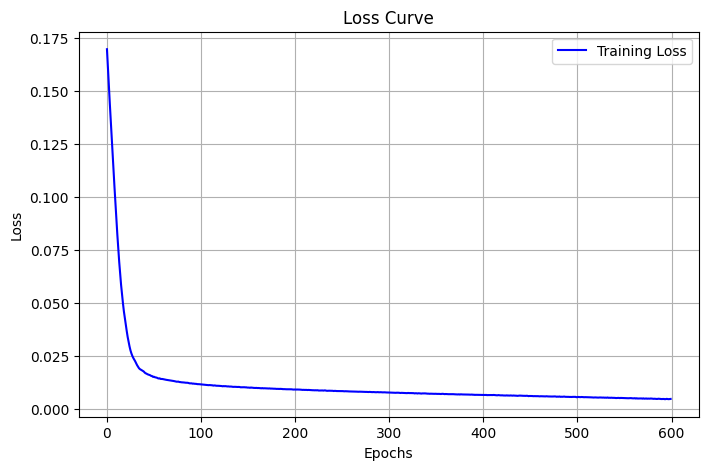

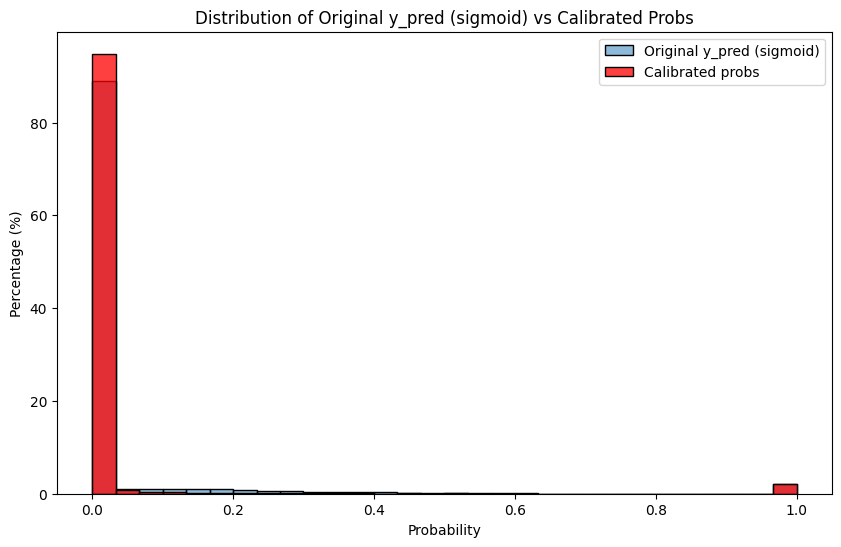

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37093
         1.0       0.82      0.90      0.86       884

    accuracy                           0.99     37977
   macro avg       0.91      0.95      0.93     37977
weighted avg       0.99      0.99      0.99     37977

AUROC: 0.9944970773595485


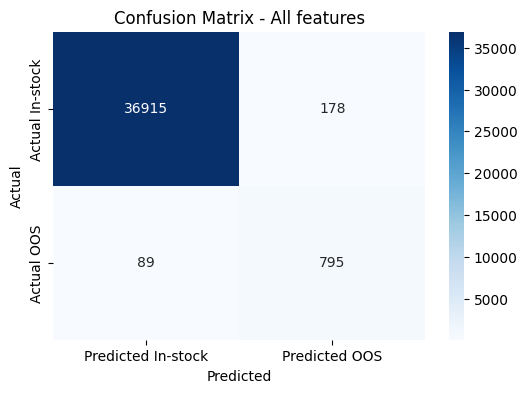

In [43]:
# using all features
X_original_all = data_all.drop('isOOS', axis=1)
y_original_all = data_all['isOOS']
X = X_original_all
y = y_original_all
# Split the dataset (before SMOTE to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data

# Apply SMOTE on the training data only
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)  # Change to float32
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)  # Change to float32
y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)


input_size = X_train_resampled.shape[1]
model = FCNN(input_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = FocalLoss(alpha=0.90, gamma=2.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model = train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, device, epochs = 600)
calibrator = calibrate_model(trained_model, X_train_tensor, y_train_tensor, device)
plt = evaluate_model(trained_model, calibrator, X_test_tensor, y_test_tensor, device)
plt.title(f'Confusion Matrix - All features')
plt.show()


In [44]:
X_original = data.drop('isOOS', axis=1)
y_original = data['isOOS']

In [45]:
models = []
calibrators = []
plts = []

Using top 20 features: ['irTimeSincePrevOOS', 'irTimeSincePrevOrder', 'irTimeSinceLastDelivered', 'resTimeSincePrevRestock', 'resQty3d', 'irTimeSincePrevRestock', 'resNumOrders3d', 'resNumOrders1d', 'resNumOOS1w', 'resQty1d', 'irNumOrders3d', 'irQty1w', 'resNumOrders3h', 'irPrevRestockTime', 'isWeekend', 'irQty24h', 'dd', 'irNumOOS1w', 'irNumOOS3d', 'resNumOrders1w']
Epoch [10/600], Loss: 0.0992
Epoch [20/600], Loss: 0.0631
Epoch [30/600], Loss: 0.0369
Epoch [40/600], Loss: 0.0226
Epoch [50/600], Loss: 0.0176
Epoch [60/600], Loss: 0.0160
Epoch [70/600], Loss: 0.0148
Epoch [80/600], Loss: 0.0140
Epoch [90/600], Loss: 0.0132
Epoch [100/600], Loss: 0.0125
Epoch [110/600], Loss: 0.0118
Epoch [120/600], Loss: 0.0113
Epoch [130/600], Loss: 0.0110
Epoch [140/600], Loss: 0.0106
Epoch [150/600], Loss: 0.0103
Epoch [160/600], Loss: 0.0102
Epoch [170/600], Loss: 0.0100
Epoch [180/600], Loss: 0.0099
Epoch [190/600], Loss: 0.0098
Epoch [200/600], Loss: 0.0097
Epoch [210/600], Loss: 0.0096
Epoch [22

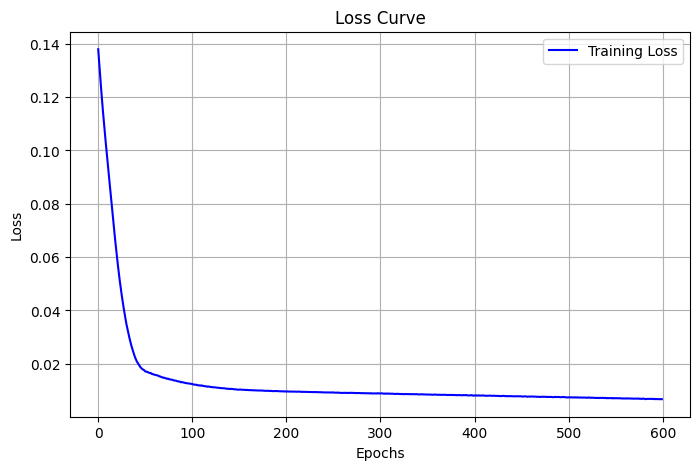

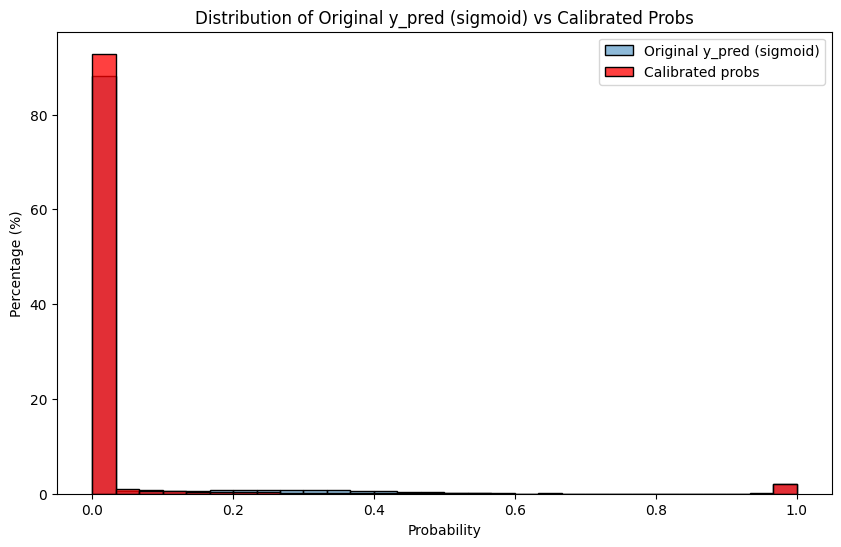

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37093
         1.0       0.82      0.90      0.86       884

    accuracy                           0.99     37977
   macro avg       0.91      0.95      0.93     37977
weighted avg       0.99      0.99      0.99     37977

AUROC: 0.9951444961685517


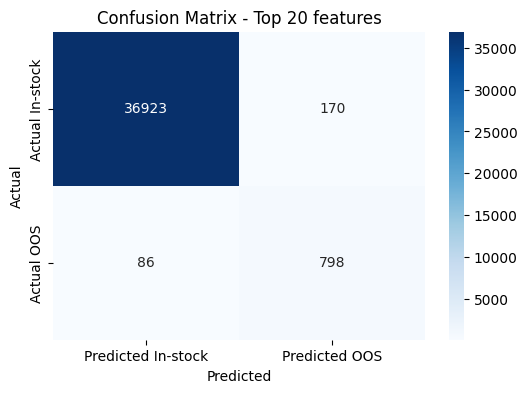

Using top 10 features: ['irTimeSincePrevOOS', 'irTimeSincePrevOrder', 'irTimeSinceLastDelivered', 'resTimeSincePrevRestock', 'resQty3d', 'irTimeSincePrevRestock', 'resNumOrders3d', 'resNumOrders1d', 'resNumOOS1w', 'resQty1d']
Epoch [10/600], Loss: 0.1154
Epoch [20/600], Loss: 0.0679
Epoch [30/600], Loss: 0.0366
Epoch [40/600], Loss: 0.0233
Epoch [50/600], Loss: 0.0179
Epoch [60/600], Loss: 0.0159
Epoch [70/600], Loss: 0.0147
Epoch [80/600], Loss: 0.0136
Epoch [90/600], Loss: 0.0127
Epoch [100/600], Loss: 0.0121
Epoch [110/600], Loss: 0.0115
Epoch [120/600], Loss: 0.0112
Epoch [130/600], Loss: 0.0111
Epoch [140/600], Loss: 0.0110
Epoch [150/600], Loss: 0.0108
Epoch [160/600], Loss: 0.0108
Epoch [170/600], Loss: 0.0107
Epoch [180/600], Loss: 0.0106
Epoch [190/600], Loss: 0.0106
Epoch [200/600], Loss: 0.0105
Epoch [210/600], Loss: 0.0106
Epoch [220/600], Loss: 0.0105
Epoch [230/600], Loss: 0.0105
Epoch [240/600], Loss: 0.0104
Epoch [250/600], Loss: 0.0104
Epoch [260/600], Loss: 0.0104
Epo

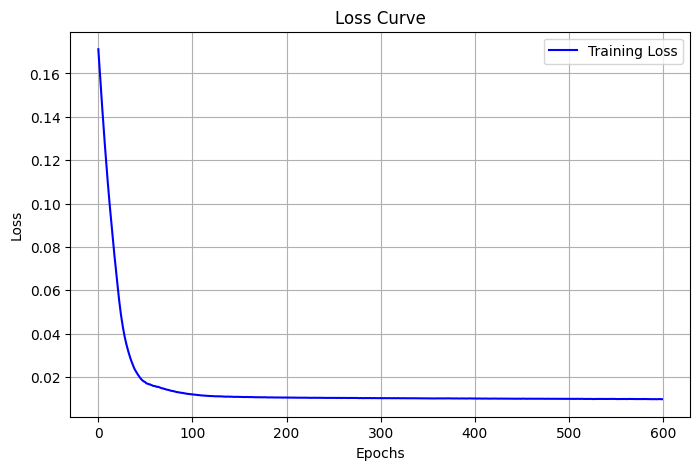

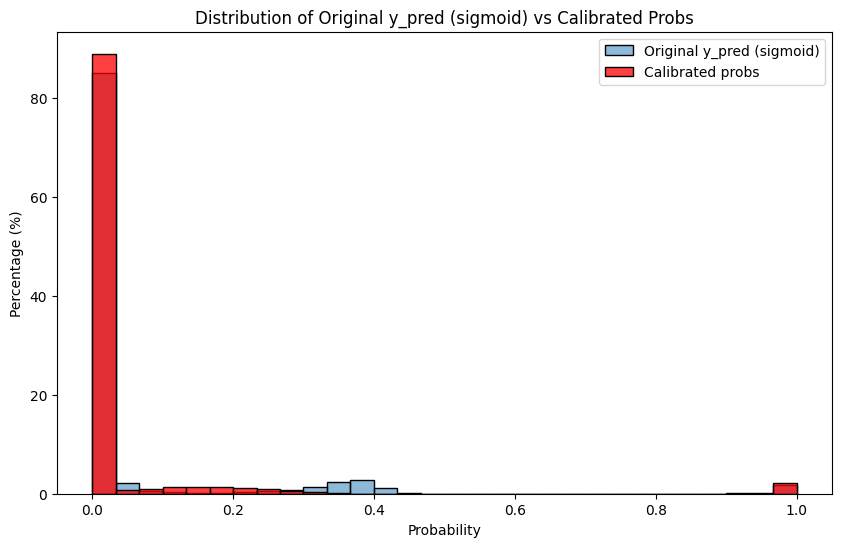

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37093
         1.0       0.99      0.89      0.94       884

    accuracy                           1.00     37977
   macro avg       0.99      0.95      0.97     37977
weighted avg       1.00      1.00      1.00     37977

AUROC: 0.9949202524216678


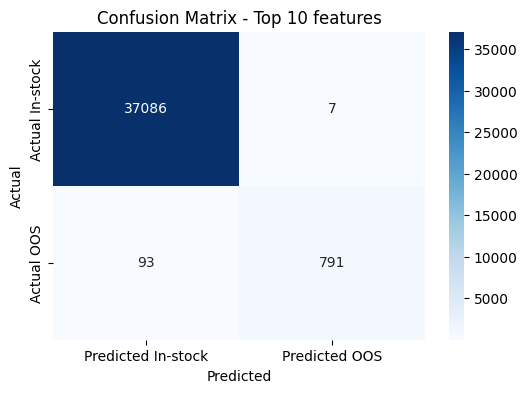

Using top 5 features: ['irTimeSincePrevOOS', 'irTimeSincePrevOrder', 'irTimeSinceLastDelivered', 'resTimeSincePrevRestock', 'resQty3d']
Epoch [10/600], Loss: 0.1237
Epoch [20/600], Loss: 0.0673
Epoch [30/600], Loss: 0.0292
Epoch [40/600], Loss: 0.0199
Epoch [50/600], Loss: 0.0178
Epoch [60/600], Loss: 0.0161
Epoch [70/600], Loss: 0.0150
Epoch [80/600], Loss: 0.0139
Epoch [90/600], Loss: 0.0131
Epoch [100/600], Loss: 0.0124
Epoch [110/600], Loss: 0.0118
Epoch [120/600], Loss: 0.0116
Epoch [130/600], Loss: 0.0114
Epoch [140/600], Loss: 0.0112
Epoch [150/600], Loss: 0.0111
Epoch [160/600], Loss: 0.0110
Epoch [170/600], Loss: 0.0110
Epoch [180/600], Loss: 0.0109
Epoch [190/600], Loss: 0.0108
Epoch [200/600], Loss: 0.0108
Epoch [210/600], Loss: 0.0107
Epoch [220/600], Loss: 0.0107
Epoch [230/600], Loss: 0.0107
Epoch [240/600], Loss: 0.0107
Epoch [250/600], Loss: 0.0107
Epoch [260/600], Loss: 0.0106
Epoch [270/600], Loss: 0.0106
Epoch [280/600], Loss: 0.0106
Epoch [290/600], Loss: 0.0106
Epo

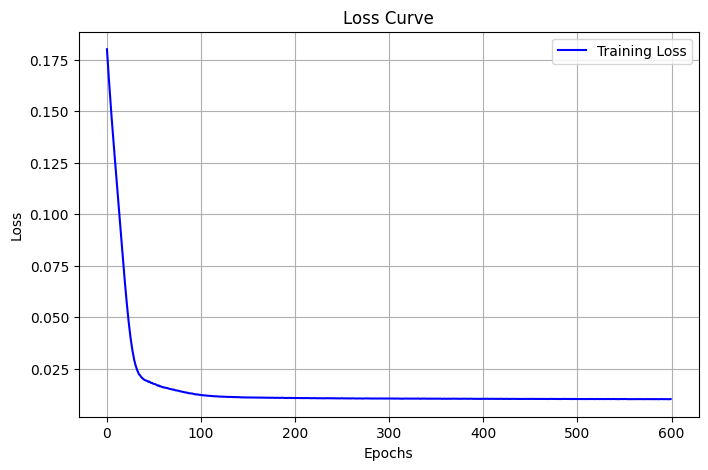

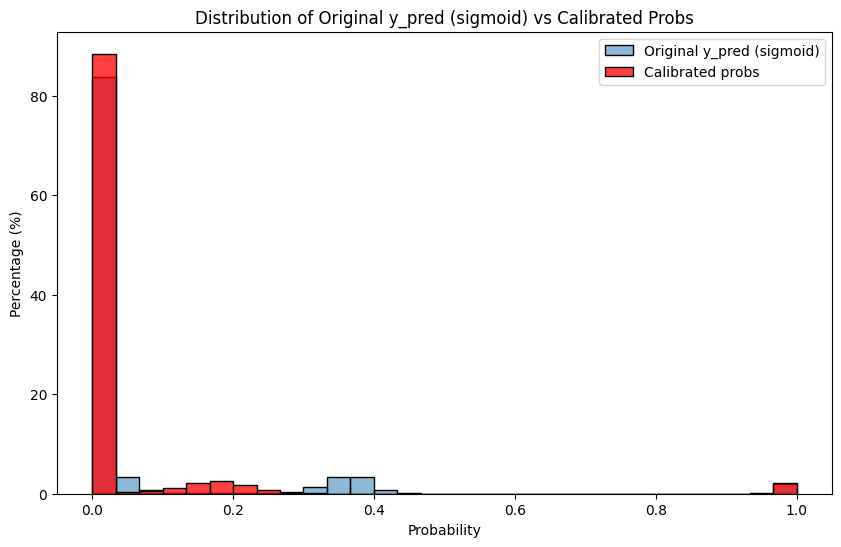

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37093
         1.0       1.00      0.89      0.94       884

    accuracy                           1.00     37977
   macro avg       1.00      0.95      0.97     37977
weighted avg       1.00      1.00      1.00     37977

AUROC: 0.9939987579220285


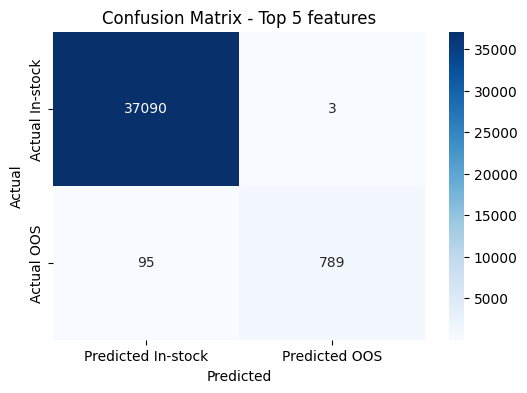

In [46]:
for i in [20,10,5]:
  top_features = top_20_features_from_ML[:i]
  X = X_original[top_features]
  y = y_original
  print(f"Using top {i} features: {top_features}")
  # Split the dataset (before SMOTE to prevent data leakage)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  # Standardize features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data

  # Apply SMOTE on the training data only
  smote = SMOTE(sampling_strategy=0.2, random_state=42)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

  X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.int64)
  y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)
  y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)  # Change to float32
  y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)  # Change to float32
  y_train_tensor = y_train_tensor.view(-1, 1)
  y_test_tensor = y_test_tensor.view(-1, 1)


  input_size = X_train_resampled.shape[1]
  model = FCNN(input_size)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = FocalLoss(alpha=0.90, gamma=2.0).to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  trained_model = train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, device, epochs = 600)
  calibrator = calibrate_model(trained_model, X_train_tensor, y_train_tensor, device)
  plt = evaluate_model(trained_model, calibrator, X_test_tensor, y_test_tensor, device)
  plt.title(f'Confusion Matrix - Top {i} features')
  plt.show()
  models.append(trained_model)
  calibrators.append(calibrator)
  plts.append(plt)

